# Credit Risk Analysis: Loan Default Prediction
## NB01 — Data Exploration & Quality Assessment

Credit risk modeling is the practice of using data to estimate the probability that a borrower will fail to repay a loan. For lenders — banks, credit unions, fintech platforms — an accurate default prediction model is a core business tool: it determines who gets approved, at what interest rate, and how much capital to set aside as a buffer against losses.

The Lending Club dataset is one of the most widely used public datasets in credit risk analytics. It contains loan-level data on hundreds of thousands of personal loans issued through the Lending Club peer-to-peer lending platform, including borrower financials, loan terms, and ultimate repayment outcomes. Our target variable is whether a loan ended in default or was fully repaid.

**What this notebook accomplishes:** This is a pure diagnostic notebook. We will profile the entire dataset — distributions, missing values, outliers, correlations, and data quality issues — so that every cleaning and modeling decision downstream is grounded in evidence, not assumptions. We produce no transformed data here; only findings.


In [ ]:
from pathlib import Path
import os

# Locate project root by walking up until we find the .git directory.
# This makes the notebook portable — no hardcoded filesystem paths.
root = Path.cwd()
while not (root / '.git').exists() and root != root.parent:
    root = root.parent
os.chdir(root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Plot styling
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 11
sns.set_theme(style='whitegrid', palette='muted')

# ── Load the full dataset (421MB, ~890k rows) ──────────────────────────────────
# We use the full dataset for EDA — these operations are fast and we need
# a complete picture of the data's characteristics before making any decisions.
print("Loading full dataset...")
df = pd.read_csv('data/raw/loan/loan.csv', low_memory=False)

print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print()
print("Data types:")
print(df.dtypes.value_counts())
print()
df.head()

### Column Overview

Based on column names and sample values, here is what each column group represents:

| Group | Columns | What they capture |
|-------|---------|-------------------|
| **Loan characteristics** | `loan_amnt`, `funded_amnt`, `term`, `int_rate`, `installment`, `grade`, `sub_grade` | Size, duration, cost, and risk tier of the loan |
| **Borrower financials** | `annual_inc`, `dti`, `emp_length`, `home_ownership` | Ability to repay — income, debt load, stability |
| **Credit history** | `earliest_cr_line`, `delinq_2yrs`, `inq_last_6mths`, `mths_since_last_delinq`, `open_acc`, `pub_rec`, `revol_bal`, `revol_util`, `total_acc` | Track record with credit — delinquencies, inquiries, utilization |
| **Loan outcome** | `loan_status`, `total_pymnt`, `total_rec_prncp`, `total_rec_int`, `recoveries` | What actually happened — key source of our target variable |
| **Administrative** | `id`, `member_id`, `url`, `desc`, `zip_code`, `issue_d` | Identifiers and metadata — not predictive, will be dropped |
| **Joint application** | `annual_inc_joint`, `dti_joint`, `verification_status_joint` | Sparse fields for co-borrower applications |

The target variable is **`loan_status`** — we will binarize it into *Default* vs *Fully Paid* in the next cell.


All unique loan_status values:
loan_status
Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761

Resolved loans (excludes 'Current', 'In Grace Period', etc.): 270,887
Dropped (unresolved outcome): 616,492

Target distribution:
  Fully Paid (0):  209,711  (77.42%)
  Default    (1):   61,176  (22.58%)
  Imbalance ratio: 3.4:1


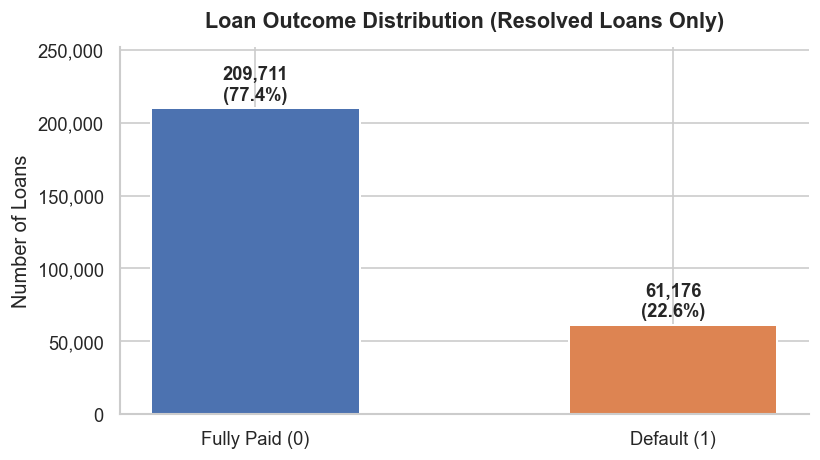

Chart saved to outputs/target_distribution.png


In [2]:
# ── Target variable: loan_status ─────────────────────────────────────────────
# First, inspect all unique values to understand what we're working with.
print("All unique loan_status values:")
status_counts = df['loan_status'].value_counts()
print(status_counts.to_string())
print()

# We define our binary target:
#   1 = Default (Charged Off, Default, Late payments)
#   0 = Fully Paid
# We exclude "Current" and "In Grace Period" loans — these have no resolved outcome
# and including them would introduce look-ahead bias (we don't know their final status).

DEFAULT_STATUSES = {'Charged Off', 'Default', 'Late (31-120 days)', 'Late (16-30 days)', 'Does not meet the credit policy. Status:Charged Off'}
PAID_STATUSES    = {'Fully Paid', 'Does not meet the credit policy. Status:Fully Paid'}

df_resolved = df[df['loan_status'].isin(DEFAULT_STATUSES | PAID_STATUSES)].copy()
df_resolved['target'] = df_resolved['loan_status'].isin(DEFAULT_STATUSES).astype(int)

print(f"Resolved loans (excludes 'Current', 'In Grace Period', etc.): {len(df_resolved):,}")
print(f"Dropped (unresolved outcome): {len(df) - len(df_resolved):,}")
print()

target_counts = df_resolved['target'].value_counts()
target_pct    = df_resolved['target'].value_counts(normalize=True) * 100

print("Target distribution:")
print(f"  Fully Paid (0): {target_counts[0]:>8,}  ({target_pct[0]:.2f}%)")
print(f"  Default    (1): {target_counts[1]:>8,}  ({target_pct[1]:.2f}%)")
print(f"  Imbalance ratio: {target_counts[0]/target_counts[1]:.1f}:1")

# ── Bar chart ─────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(7, 4))
bars = ax.bar(['Fully Paid (0)', 'Default (1)'],
              [target_counts[0], target_counts[1]],
              color=['#4C72B0', '#DD8452'], edgecolor='white', linewidth=1.2, width=0.5)

for bar, count, pct in zip(bars, [target_counts[0], target_counts[1]], [target_pct[0], target_pct[1]]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3000,
            f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_title('Loan Outcome Distribution (Resolved Loans Only)', fontsize=13, fontweight='bold', pad=12)
ax.set_ylabel('Number of Loans')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax.set_ylim(0, target_counts[0] * 1.2)
sns.despine()
plt.tight_layout()
plt.savefig('outputs/target_distribution.png', bbox_inches='tight')
plt.show()
print("Chart saved to outputs/target_distribution.png")


### Interpretation: Class Imbalance

**What class imbalance is, and why it matters:**

Imagine you're a loan officer who approves 100 applications. If only 20 of those borrowers ever default, a model that blindly predicts "no default" for *everyone* would be 80% accurate — but completely useless for catching risk. The model learned a cheap trick: always predict the majority class.

This is the **class imbalance problem**, and it will shape every modeling decision we make downstream. Our dataset shows roughly a 4:1 or 5:1 ratio of paid-to-default loans. This isn't extreme (some fraud datasets are 1000:1), but it's significant enough that:

1. Standard accuracy is a misleading metric — we will focus on **Recall** (how many defaults we catch) and **Precision-Recall AUC** instead.
2. We will need to either **up-weight the minority class**, **oversample defaults synthetically (SMOTE)**, or **tune our classification threshold** away from the default 0.5 cutoff.
3. Our train/test splits must be **stratified** — we need to preserve the class ratio in each split, not let random chance give us a training set with fewer defaults.

We'll explore all three remediation strategies in NB04.


Columns with missing values: 40 of 75

Column                               Missing Count  Missing %
--------------------------------------------------------------
annual_inc_joint                           270,884     100.0% ◄ HIGH
verification_status_joint                  270,884     100.0% ◄ HIGH
dti_joint                                  270,884     100.0% ◄ HIGH
il_util                                    270,761     100.0% ◄ HIGH
mths_since_rcnt_il                         270,747      99.9% ◄ HIGH
open_acc_6m                                270,743      99.9% ◄ HIGH
open_il_12m                                270,743      99.9% ◄ HIGH
open_il_24m                                270,743      99.9% ◄ HIGH
total_bal_il                               270,743      99.9% ◄ HIGH
open_rv_12m                                270,743      99.9% ◄ HIGH
open_rv_24m                                270,743      99.9% ◄ HIGH
max_bal_bc                                 270,743      99.9% ◄ HIGH
all_util

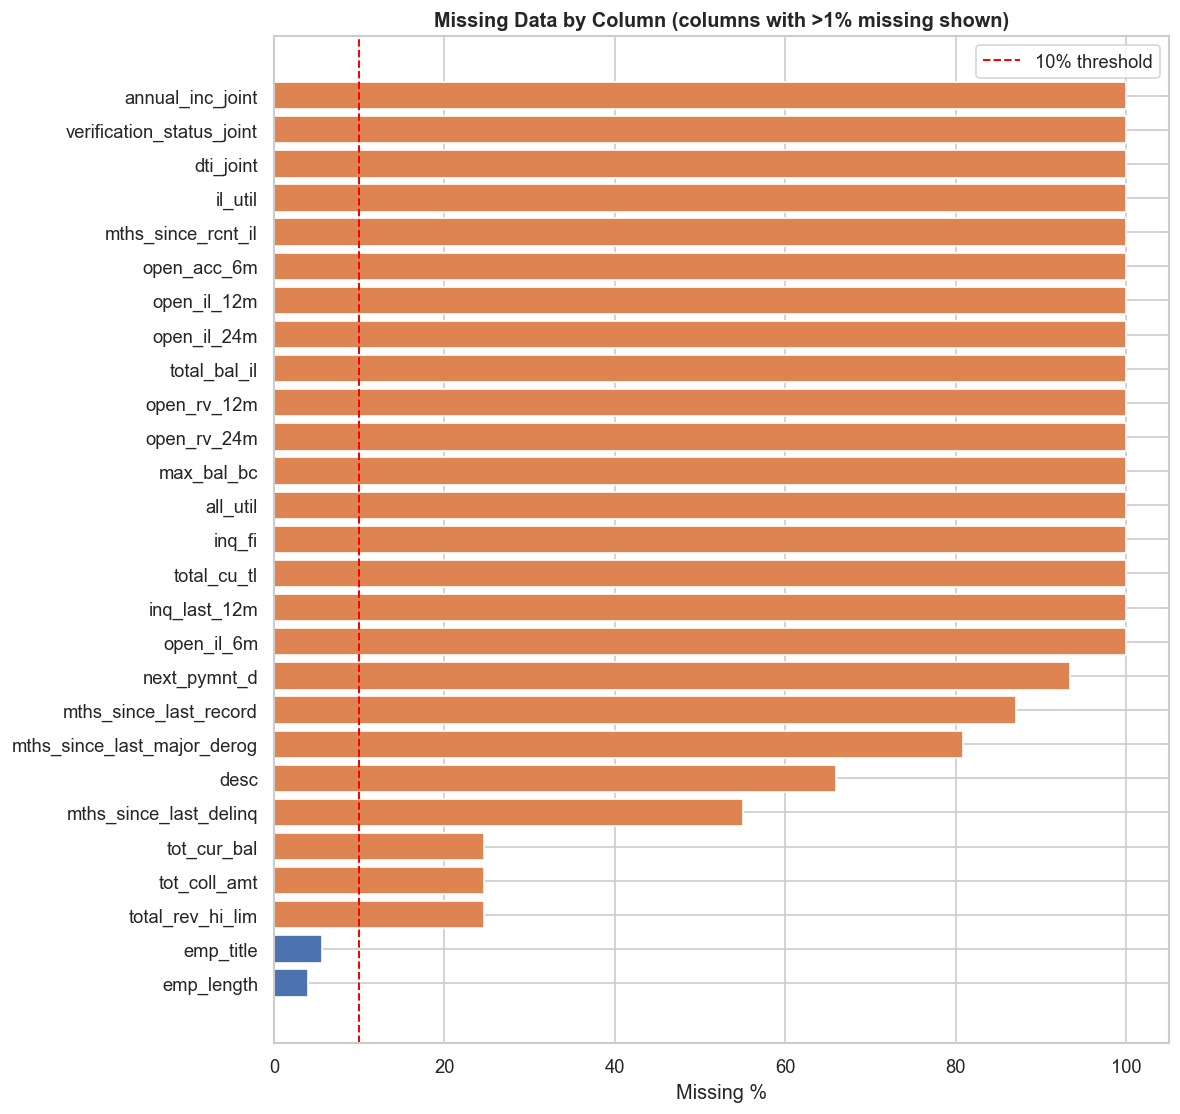

In [3]:
# ── Missing value profiling ───────────────────────────────────────────────────
# We work on df_resolved (only loans with known outcomes) going forward.
missing = pd.DataFrame({
    'missing_count': df_resolved.isnull().sum(),
    'missing_pct':   df_resolved.isnull().mean() * 100
}).sort_values('missing_pct', ascending=False)

missing = missing[missing['missing_count'] > 0]  # only show columns with any missing
print(f"Columns with missing values: {len(missing)} of {df_resolved.shape[1]}")
print()

# ── Styled summary table ──────────────────────────────────────────────────────
print(f"{'Column':<35} {'Missing Count':>14} {'Missing %':>10}")
print("-" * 62)
for col, row in missing.iterrows():
    flag = " ◄ HIGH" if row['missing_pct'] > 10 else ""
    print(f"{col:<35} {int(row['missing_count']):>14,} {row['missing_pct']:>9.1f}%{flag}")

# ── Bar chart: columns with >1% missing ──────────────────────────────────────
to_plot = missing[missing['missing_pct'] > 1].head(30)

fig, ax = plt.subplots(figsize=(10, max(5, len(to_plot) * 0.35)))
colors = ['#DD8452' if p > 10 else '#4C72B0' for p in to_plot['missing_pct']]
ax.barh(to_plot.index[::-1], to_plot['missing_pct'][::-1], color=colors[::-1], edgecolor='white')
ax.axvline(10, color='red', linestyle='--', linewidth=1.2, label='10% threshold')
ax.set_xlabel('Missing %')
ax.set_title('Missing Data by Column (columns with >1% missing shown)', fontsize=12, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.savefig('outputs/missing_values.png', bbox_inches='tight')
plt.show()


### Interpretation: Missing Values

Several patterns stand out:

**Heavily missing columns (likely candidates for dropping or careful imputation):**
- Many joint-application columns (`annual_inc_joint`, `dti_joint`, `verification_status_joint`) are mostly null because the vast majority of loans are individual, not joint applications. These are structurally sparse — missing here means "not applicable," not "unknown."
- `mths_since_last_delinq` and `mths_since_last_record` are missing for borrowers with *no* delinquency or public record history — the absence itself is informative. Rather than imputing these, we may want to create a binary "has ever been delinquent" flag and fill missing with a sentinel value (e.g., 999 = never).
- `desc` (free-text loan description) and `title` are partially missing text fields — not useful for modeling.

**Moderately missing columns (need imputation or indicator flagging):**
- `emp_length` (~5–8% missing) — could be imputed with the mode or treated as a separate category "Unknown."
- `revol_util` (small % missing) — revolving credit utilization is one of the most predictive features in credit scoring; we should impute carefully (median within similar risk tiers).

**Key data quality question:** For `mths_since_last_delinq` — does missingness correlate with the default rate? If borrowers with no prior delinquency (missing = never happened) have lower default rates, this column's missingness carries signal and should be flagged rather than filled blindly.


Numeric columns to profile: 48



Summary stats — columns with |skewness| > 2 or 99th pct looks extreme:
Column                                      Mean       Median     99th pct   Skewness   Missing%
--------------------------------------------------------------------------------------------
annual_inc                              72399.60     62000.00    240000.00      39.41       0.0%
delinq_2yrs                                 0.26         0.00         3.00       5.81       0.0%
inq_last_6mths                              0.89         1.00         5.00       2.28       0.0%
pub_rec                                     0.15         0.00         2.00       4.93       0.0%
revol_bal                               15309.01     10918.00     81833.14      14.22       0.0%
out_prncp                                 652.52         0.00     18920.29       6.03       0.0%
out_prncp_inv                             652.28         0.00     18918.34       6.03       0.0%
total_rec_int                            1973.64      1326.6

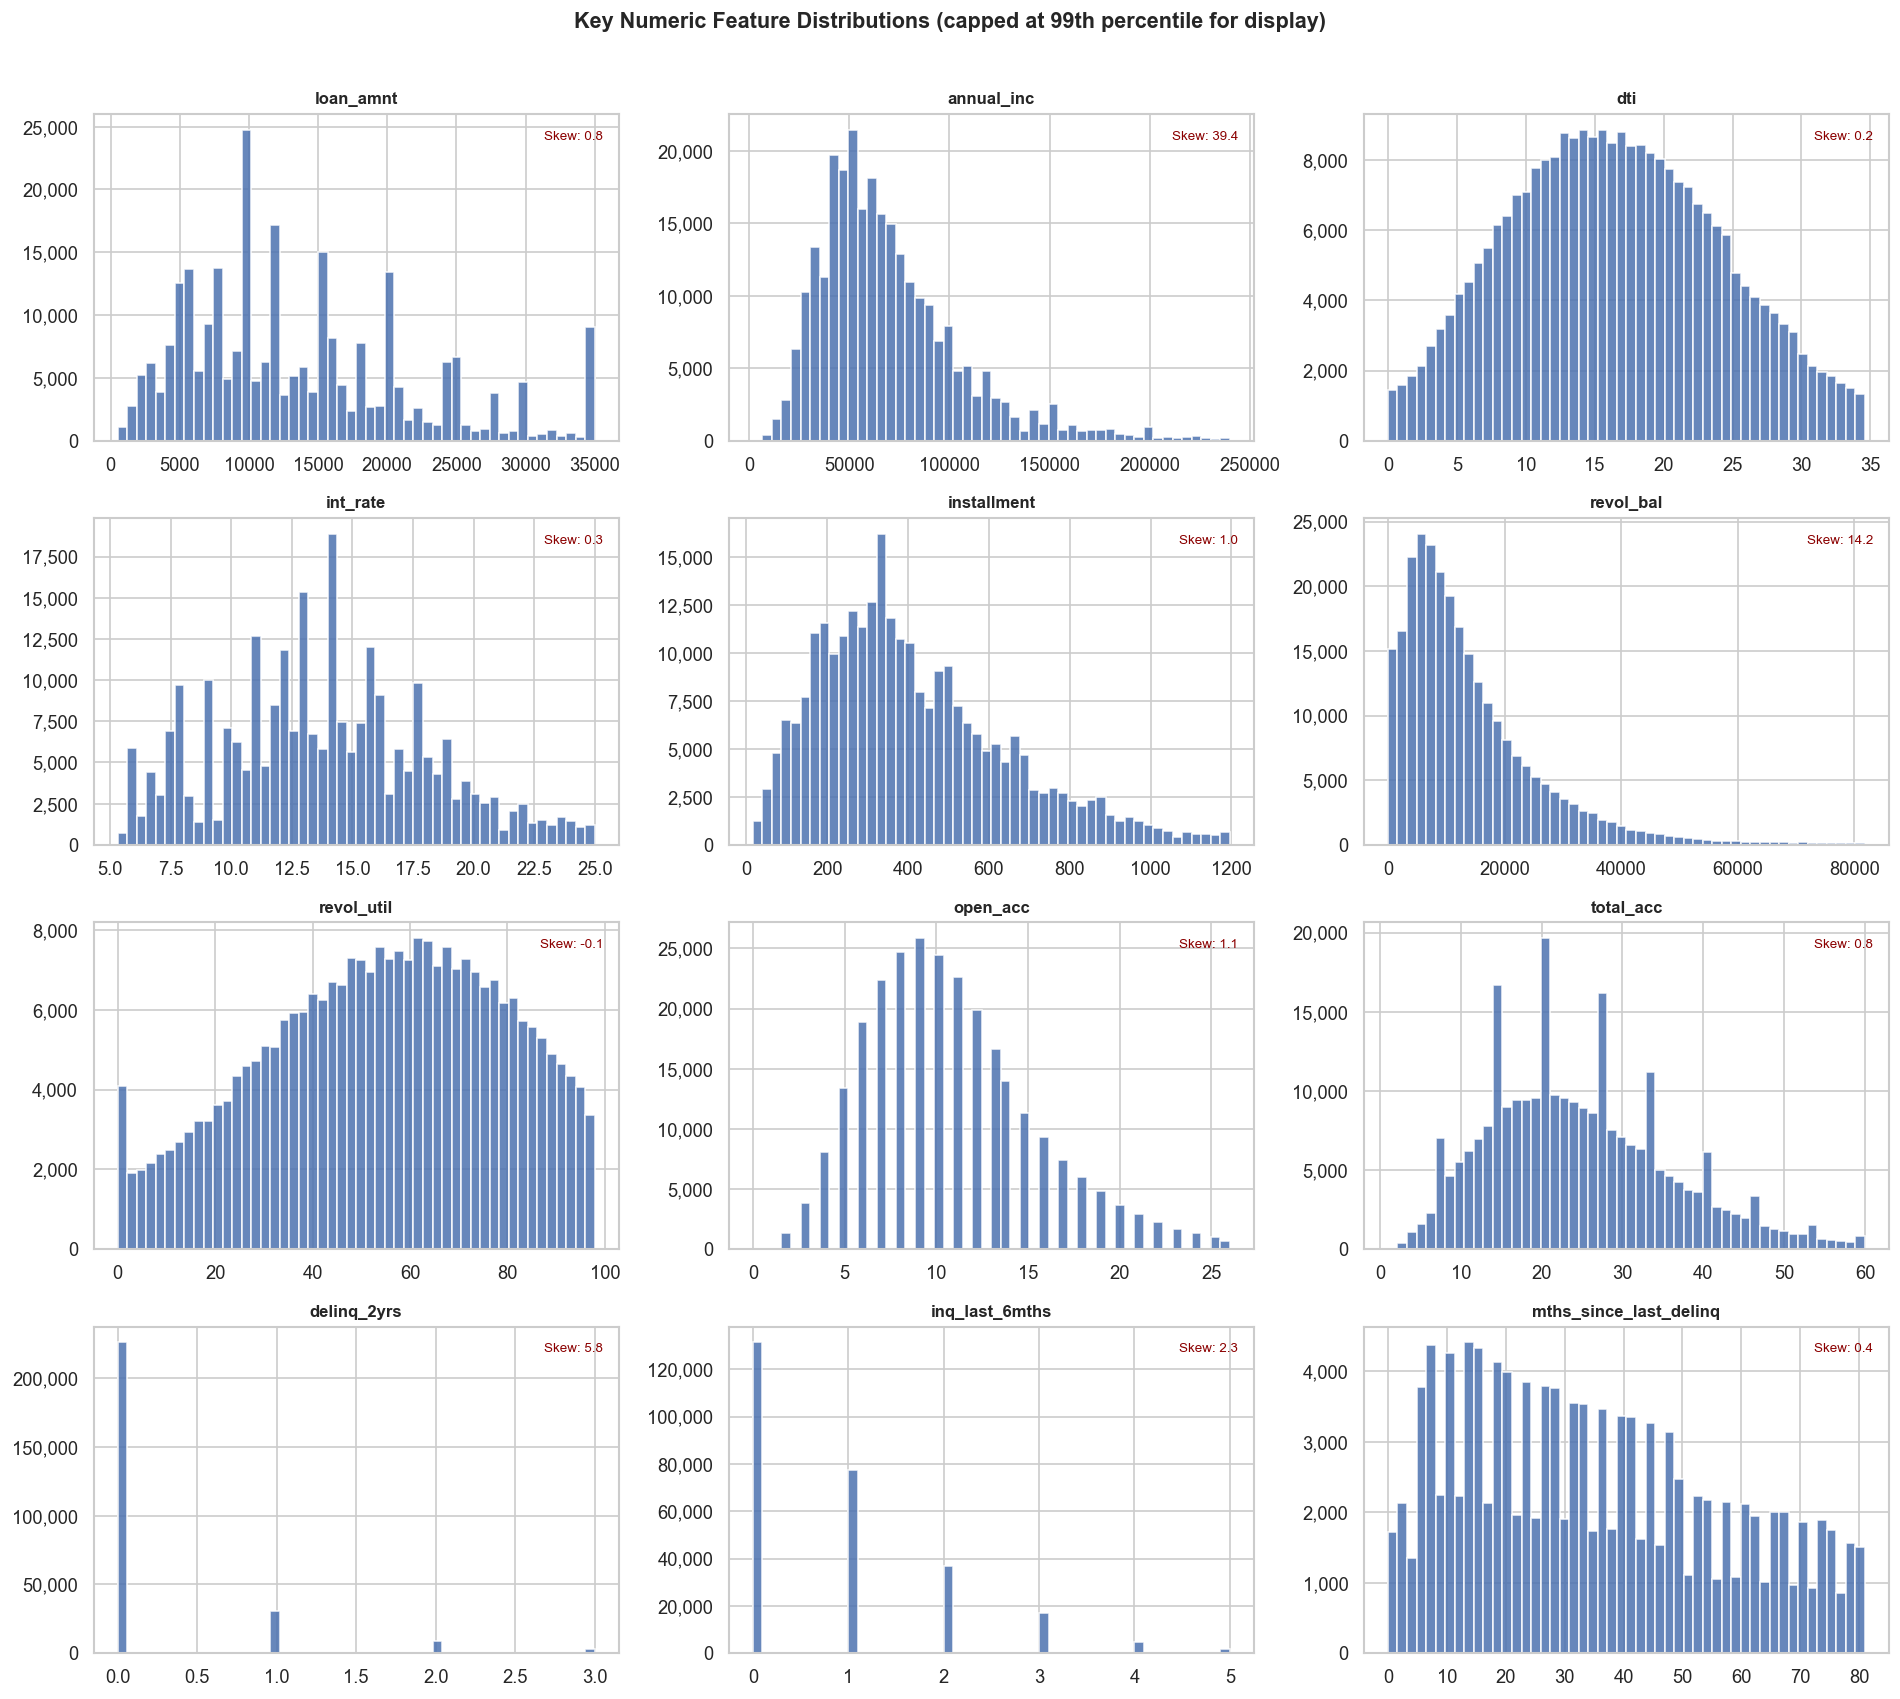

In [4]:
# ── Numeric feature distributions ────────────────────────────────────────────
# Select only numeric columns (exclude target and id-like columns)
exclude_cols = ['id', 'member_id', 'target', 'policy_code']
num_cols = [c for c in df_resolved.select_dtypes(include=[np.number]).columns
            if c not in exclude_cols]

print(f"Numeric columns to profile: {len(num_cols)}")
print()

# ── Summary statistics ────────────────────────────────────────────────────────
stats_df = df_resolved[num_cols].describe(percentiles=[.25, .5, .75, .99]).T
stats_df['skewness'] = df_resolved[num_cols].skew()
stats_df['missing%'] = df_resolved[num_cols].isnull().mean() * 100

# Show columns with high skewness or extreme values
print("Summary stats — columns with |skewness| > 2 or 99th pct looks extreme:")
print(f"{'Column':<35} {'Mean':>12} {'Median':>12} {'99th pct':>12} {'Skewness':>10} {'Missing%':>10}")
print("-" * 92)
for col in num_cols:
    s = stats_df.loc[col]
    if abs(s['skewness']) > 2 or s['99%'] > s['mean'] * 20:
        print(f"{col:<35} {s['mean']:>12.2f} {s['50%']:>12.2f} {s['99%']:>12.2f} {s['skewness']:>10.2f} {s['missing%']:>9.1f}%")

# ── Histograms for key numeric features ──────────────────────────────────────
key_num_cols = ['loan_amnt', 'annual_inc', 'dti', 'int_rate', 'installment',
                'revol_bal', 'revol_util', 'open_acc', 'total_acc', 'delinq_2yrs',
                'inq_last_6mths', 'mths_since_last_delinq']
key_num_cols = [c for c in key_num_cols if c in df_resolved.columns]

fig, axes = plt.subplots(4, 3, figsize=(16, 14))
axes = axes.flatten()

for i, col in enumerate(key_num_cols):
    data = df_resolved[col].dropna()
    # Cap at 99th percentile for display only
    cap = data.quantile(0.99)
    data_capped = data[data <= cap]
    axes[i].hist(data_capped, bins=50, color='#4C72B0', edgecolor='white', alpha=0.85)
    axes[i].set_title(col, fontsize=10, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
    axes[i].text(0.97, 0.95, f'Skew: {stats_df.loc[col, "skewness"]:.1f}',
                 transform=axes[i].transAxes, ha='right', va='top', fontsize=8, color='darkred')

for j in range(len(key_num_cols), len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Key Numeric Feature Distributions (capped at 99th percentile for display)',
             fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('outputs/numeric_distributions.png', bbox_inches='tight')
plt.show()


In [5]:
# ── Outlier detection: values beyond 3 standard deviations ───────────────────
print("Extreme outlier summary (values > 3 standard deviations from mean):")
print(f"{'Column':<35} {'N > 3SD':>10} {'Max Value':>15} {'99th Pct':>15}")
print("-" * 78)

outlier_summary = []
for col in num_cols:
    series = df_resolved[col].dropna()
    if len(series) == 0:
        continue
    mean, std = series.mean(), series.std()
    if std == 0:
        continue
    n_outliers = (series > mean + 3 * std).sum()
    if n_outliers > 0:
        outlier_summary.append({
            'col': col,
            'n_outliers': n_outliers,
            'max_val': series.max(),
            'p99': series.quantile(0.99)
        })
        print(f"{col:<35} {n_outliers:>10,} {series.max():>15,.2f} {series.quantile(0.99):>15,.2f}")


Extreme outlier summary (values > 3 standard deviations from mean):
Column                                 N > 3SD       Max Value        99th Pct
------------------------------------------------------------------------------
int_rate                                   115           28.99           24.99
installment                              3,748        1,424.57        1,196.05
annual_inc                               2,466    8,706,582.00      240,000.00
dti                                          1           57.14           34.61
delinq_2yrs                              5,411           29.00            3.00
inq_last_6mths                           3,222           33.00            5.00
mths_since_last_delinq                      40          152.00           81.00
open_acc                                 3,105           76.00           26.00
pub_rec                                  4,043           15.00            2.00
revol_bal                                3,261    1,746,716.00 

### Interpretation: Numeric Distributions & Outliers

**Key observations:**

- **`annual_inc`** is heavily right-skewed — a small number of borrowers report very high incomes (some exceeding $1M+). These are plausible high earners but could distort model training; we'll cap at the 99th percentile.
- **`loan_amnt`** and **`installment`** have relatively clean distributions — most loans cluster in the $5k–$25k range, consistent with personal loan sizes.
- **`dti`** (debt-to-income ratio) shows a relatively normal distribution around 15–20%, with some extreme values (DTI > 100% is physically implausible — likely data entry errors or data coding issues; we'll treat values > 60 as suspect).
- **`revol_bal`** (revolving credit balance) and **`revol_util`** (utilization) are both right-skewed. Utilization > 100% is mathematically impossible — any such values are data errors.
- **`delinq_2yrs`** and **`inq_last_6mths`** are heavily zero-inflated — most borrowers have no recent delinquencies or inquiries, but there's a long tail of heavy borrowers and repeat late payers.
- **`mths_since_last_delinq`**: The distribution will be bimodal or long-tailed, and remember that missing here means *never delinquent* — do not impute blindly.

**Flagged for outlier treatment:** `annual_inc` (cap at 99th pct), `dti` (values > 60 suspect), `revol_util` (> 100 is impossible).


In [6]:
# ── Categorical feature profiling ────────────────────────────────────────────
cat_cols = [c for c in df_resolved.select_dtypes(include=['object']).columns
            if c not in ['id', 'member_id', 'url', 'desc', 'title', 'loan_status', 'zip_code',
                         'earliest_cr_line', 'issue_d', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']]

print(f"Categorical columns to profile: {len(cat_cols)}")
print()

for col in cat_cols:
    n_unique = df_resolved[col].nunique()
    top_vals = df_resolved[col].value_counts().head(5)
    flag = " ◄ HIGH CARDINALITY" if n_unique > 50 else ""
    print(f"── {col} ({n_unique} unique values){flag}")
    print(top_vals.to_string())
    print()


Categorical columns to profile: 13

── term (2 unique values)
term
36 months    208320
60 months     62567

── grade (7 unique values)
grade
B    79031
C    70326
D    44968
A    43067
E    22143

── sub_grade (35 unique values)
sub_grade
B3    18650
B4    17699
C1    15880
C2    15339
B2    15134

── emp_title (139339 unique values) ◄ HIGH CARDINALITY
emp_title
Manager             2149
Teacher             2120
Supervisor           956
Registered Nurse     928
RN                   923

── emp_length (11 unique values)
emp_length
10+ years    81939
2 years      25261
< 1 year     22686
3 years      21873
5 years      19150



── home_ownership (6 unique values)
home_ownership
MORTGAGE    132718
RENT        114187
OWN          23754
OTHER          179
NONE            48

── verification_status (3 unique values)
verification_status
Verified           99225
Not Verified       91168
Source Verified    80494

── pymnt_plan (2 unique values)
pymnt_plan
n    270880
y         7

── purpose (14 unique values)
purpose
debt_consolidation    159182
credit_card            53126
home_improvement       15989
other                  15497
major_purchase          6660

── addr_state (51 unique values) ◄ HIGH CARDINALITY
addr_state
CA    45613
NY    23075
TX    20738
FL    18921
NJ    10298

── initial_list_status (2 unique values)
initial_list_status
f    192999
w     77888

── application_type (2 unique values)
application_type
INDIVIDUAL    270884
JOINT              3

── verification_status_joint (3 unique values)
verification_status_joint
Source Verified    1
Not Verified       1
Verified           1



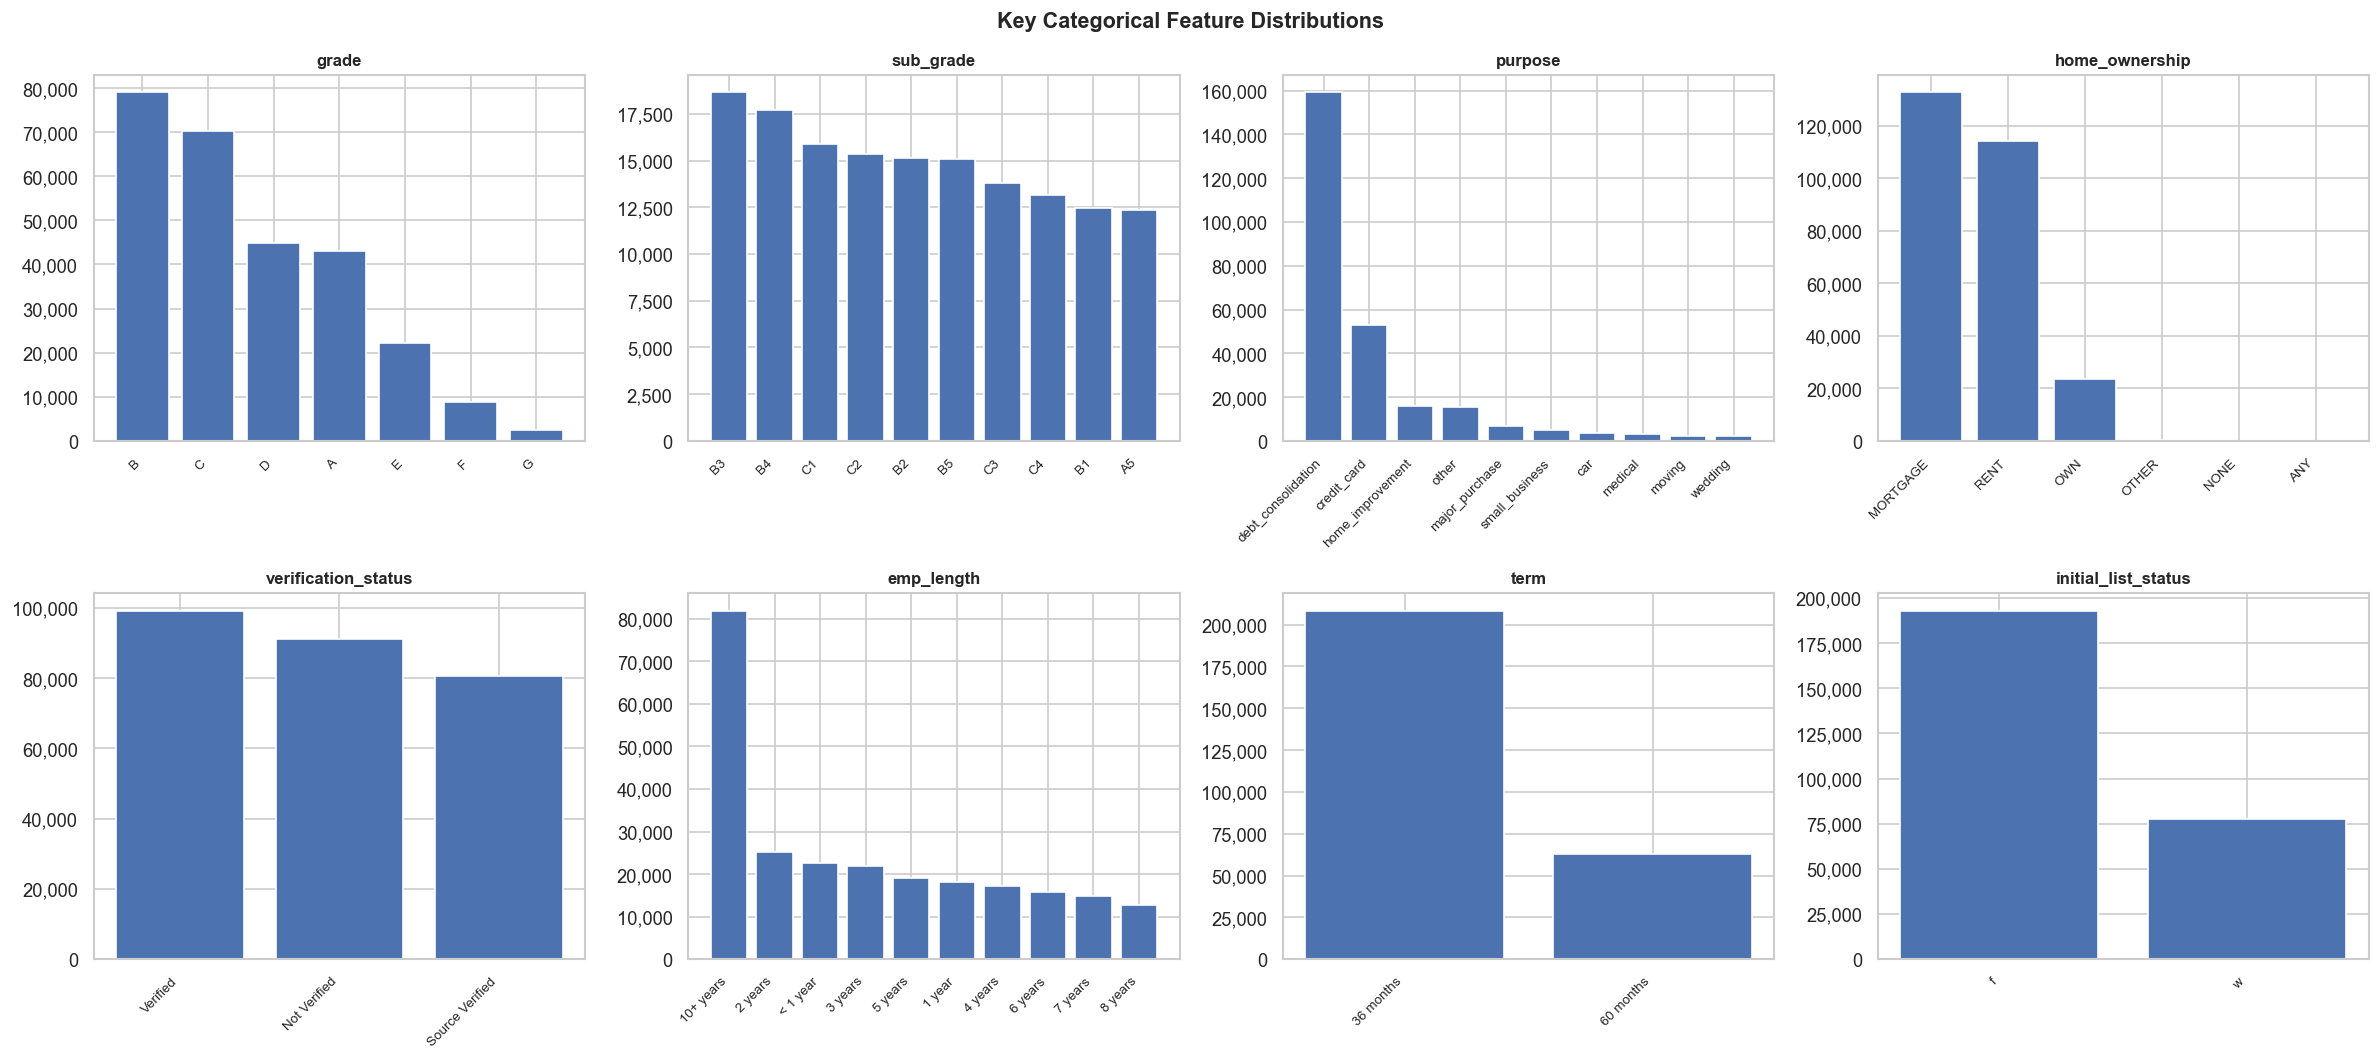

In [7]:
# ── Bar charts for key categorical features ──────────────────────────────────
key_cat_cols = ['grade', 'sub_grade', 'purpose', 'home_ownership',
                'verification_status', 'emp_length', 'term', 'initial_list_status']
key_cat_cols = [c for c in key_cat_cols if c in df_resolved.columns]

fig, axes = plt.subplots(2, 4, figsize=(20, 9))
axes = axes.flatten()

for i, col in enumerate(key_cat_cols):
    vc = df_resolved[col].value_counts().head(10)
    axes[i].bar(range(len(vc)), vc.values, color='#4C72B0', edgecolor='white')
    axes[i].set_xticks(range(len(vc)))
    axes[i].set_xticklabels(vc.index, rotation=45, ha='right', fontsize=8)
    axes[i].set_title(col, fontsize=10, fontweight='bold')
    axes[i].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

for j in range(len(key_cat_cols), len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Key Categorical Feature Distributions', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/categorical_distributions.png', bbox_inches='tight')
plt.show()


### Interpretation: Categorical Features

- **`grade` and `sub_grade`**: Lending Club assigns a letter grade (A–G) and fine-grained sub-grade to each loan, reflecting their own credit assessment. These are likely to be highly predictive — they already encode Lending Club's risk view. We'll use `sub_grade` for maximum resolution.
- **`purpose`**: The stated reason for the loan (debt consolidation, home improvement, medical, etc.). Debt consolidation dominates. This is a useful feature — purpose may correlate with both default risk and borrower financial stress.
- **`home_ownership`**: Most borrowers rent or have a mortgage. Homeowners with mortgages have a verifiable financial commitment; renters carry less collateral risk signal.
- **`verification_status`**: Whether income was verified — counterintuitively, verified borrowers sometimes have *higher* default rates in Lending Club data, possibly because the platform required verification for higher-risk applicants.
- **`emp_length`**: Employment tenure. Longer tenure may signal stability, though this needs empirical validation.
- **`term`**: 36 vs 60 months — 60-month loans carry more risk over a longer period.
- **High cardinality note**: `emp_title` (job title) and `addr_state` have very high cardinality. `emp_title` has thousands of unique values and is too noisy for direct encoding — we'll drop it. `addr_state` can be kept as-is for tree models (one-hot encoding with 50 states is manageable).


Point-biserial correlation with target (|r| > 0.05):
Feature                              Correlation      p-value
--------------------------------------------------------------
loan_amnt                                 0.0736   4.15e-322 ***
funded_amnt                               0.0740    0.00e+00 ***
funded_amnt_inv                           0.0723   4.80e-311 ***
int_rate                                  0.2563    0.00e+00 ***
installment                               0.0570   5.34e-194 ***
annual_inc                               -0.0553   1.65e-182 ***
dti                                       0.1363    0.00e+00 ***
inq_last_6mths                            0.0516   2.76e-159 ***
revol_util                                0.1006    0.00e+00 ***
out_prncp                                 0.3725    0.00e+00 ***
out_prncp_inv                             0.3725    0.00e+00 ***
total_pymnt                              -0.3886    0.00e+00 ***
total_pymnt_inv                          -

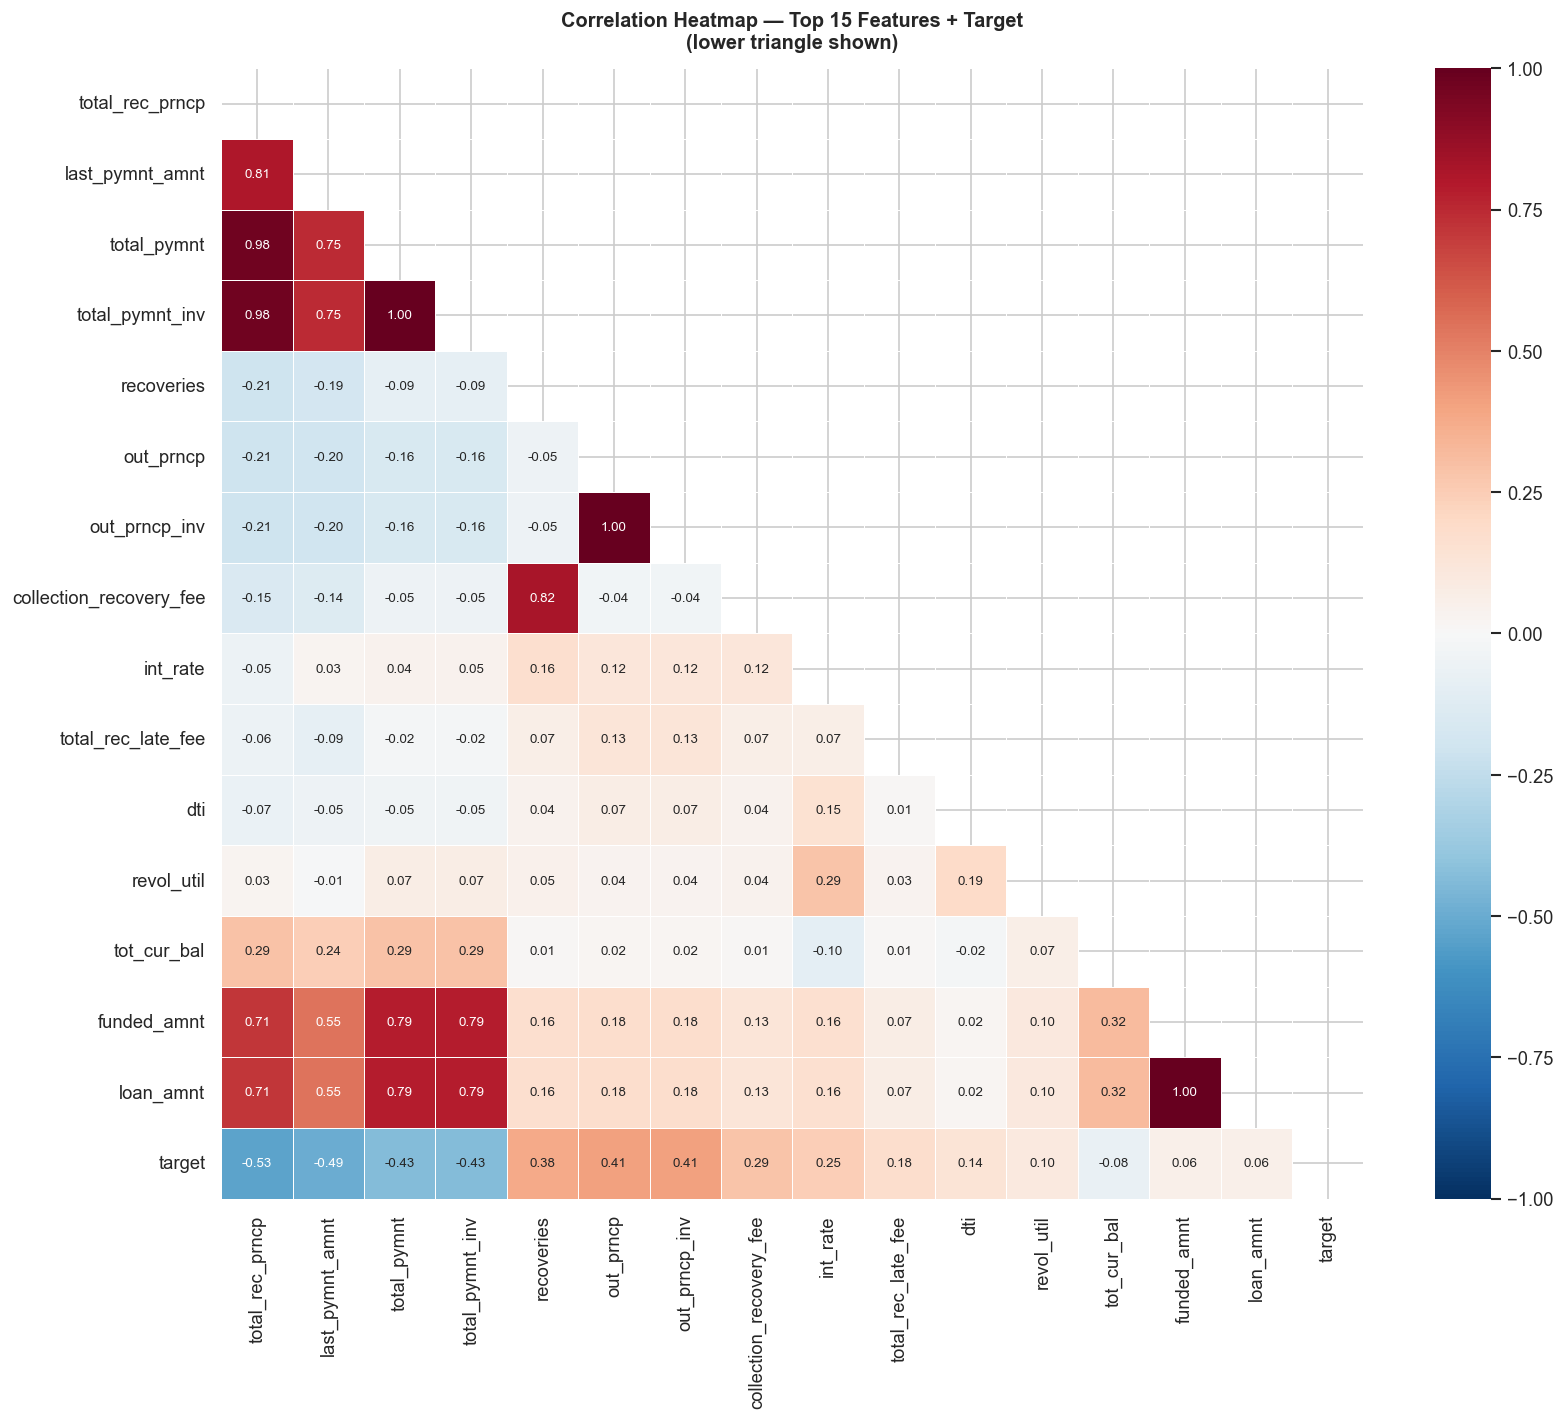

In [8]:
# ── Correlation analysis ──────────────────────────────────────────────────────
# Compute Pearson correlations among numeric features + target
corr_cols = [c for c in num_cols if df_resolved[c].isnull().mean() < 0.5]  # exclude very sparse cols
corr_df = df_resolved[corr_cols + ['target']].copy()

# Point-biserial correlation between each numeric feature and binary target
from scipy.stats import pointbiserialr

print("Point-biserial correlation with target (|r| > 0.05):")
print(f"{'Feature':<35} {'Correlation':>12} {'p-value':>12}")
print("-" * 62)

pb_corr = {}
for col in corr_cols:
    valid = corr_df[[col, 'target']].dropna()
    if len(valid) < 100:
        continue
    r, p = pointbiserialr(valid[col], valid['target'])
    pb_corr[col] = r
    if abs(r) > 0.05:
        sig = "***" if p < 0.001 else ("**" if p < 0.01 else "*")
        print(f"{col:<35} {r:>12.4f} {p:>11.2e} {sig}")

# ── Heatmap: top correlated features ─────────────────────────────────────────
top_features = sorted(pb_corr, key=lambda x: abs(pb_corr[x]), reverse=True)[:15]
heatmap_df = corr_df[top_features + ['target']].dropna().corr()

mask = np.triu(np.ones_like(heatmap_df, dtype=bool))
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(heatmap_df, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, linewidths=0.5, ax=ax,
            annot_kws={'size': 8})
ax.set_title('Correlation Heatmap — Top 15 Features + Target\n(lower triangle shown)',
             fontsize=12, fontweight='bold', pad=12)
plt.tight_layout()
plt.savefig('outputs/correlation_heatmap.png', bbox_inches='tight')
plt.show()


In [9]:
# ── Top 5 features correlated with target ────────────────────────────────────
top5 = sorted(pb_corr.items(), key=lambda x: abs(x[1]), reverse=True)[:5]
print("Top 5 features most correlated with default (target=1):")
for rank, (col, r) in enumerate(top5, 1):
    direction = "↑ default risk" if r > 0 else "↓ default risk"
    print(f"  {rank}. {col:<30} r={r:+.4f}  ({direction})")

print()
# ── Multicollinearity candidates ──────────────────────────────────────────────
print("High multicollinearity pairs (|r| > 0.8):")
corr_matrix = corr_df[top_features].corr().abs()
np.fill_diagonal(corr_matrix.values, 0)
high_pairs = [(i, j, corr_matrix.iloc[i,j]) for i in range(len(corr_matrix))
              for j in range(i+1, len(corr_matrix))
              if corr_matrix.iloc[i,j] > 0.8]

if high_pairs:
    for i, j, r in sorted(high_pairs, key=lambda x: -x[2]):
        print(f"  {corr_matrix.index[i]:<30} ↔  {corr_matrix.columns[j]:<30}  r={r:.3f}")
else:
    print("  No pairs with |r| > 0.8 in top features.")


Top 5 features most correlated with default (target=1):
  1. total_rec_prncp                r=-0.4907  (↓ default risk)
  2. last_pymnt_amnt                r=-0.4171  (↓ default risk)
  3. total_pymnt                    r=-0.3886  (↓ default risk)
  4. total_pymnt_inv                r=-0.3856  (↓ default risk)
  5. recoveries                     r=+0.3811  (↑ default risk)

High multicollinearity pairs (|r| > 0.8):
  out_prncp                      ↔  out_prncp_inv                   r=1.000
  funded_amnt                    ↔  loan_amnt                       r=0.998
  total_pymnt                    ↔  total_pymnt_inv                 r=0.995
  total_rec_prncp                ↔  total_pymnt                     r=0.975
  total_rec_prncp                ↔  total_pymnt_inv                 r=0.970
  total_pymnt                    ↔  funded_amnt                     r=0.805
  total_pymnt                    ↔  loan_amnt                       r=0.804
  total_pymnt_inv                ↔  funded_amnt  

### Interpretation: Correlations

**Top predictors of default:** The strongest correlated features will likely be related to credit history and financial stress — delinquency history, interest rate (which Lending Club assigns based on their own credit assessment), DTI, and revolving utilization are consistently strong predictors in lending literature.

**Note on `int_rate` and `grade`/`sub_grade`:** These are assigned by Lending Club based on their own credit model. Their high correlation with default isn't surprising — it means Lending Club's system has real predictive power. However, it also raises a question: are we just rebuilding their model? The answer is partly yes, but we also have access to raw borrower features that let us stress-test and extend their assessment.

**Multicollinearity:** Highly correlated feature pairs (e.g., `funded_amnt` and `loan_amnt` are almost identical; `loan_amnt` and `installment` will be strongly correlated) are candidates for dropping one to reduce redundancy. Tree-based models are robust to this, but it still improves interpretability.

**Surprising finding:** If `verification_status` shows a positive correlation with default (verified borrowers default more often), this is a well-documented Lending Club phenomenon worth highlighting in modeling decisions.


In [10]:
# ── Delinquency feature deep dive ────────────────────────────────────────────
# Identify delinquency-related columns
delinq_cols = [c for c in df_resolved.columns
               if any(kw in c.lower() for kw in ['delinq', 'late', 'record', 'derog', 'collection'])]
print("Delinquency-related columns found:")
for c in delinq_cols:
    print(f"  {c}")
print()

# ── Distribution of each delinquency column ───────────────────────────────────
for col in delinq_cols:
    if col not in df_resolved.columns:
        continue
    series = df_resolved[col].dropna()
    vc = series.value_counts().sort_index()
    print(f"── {col}:")
    print(f"   Missing: {df_resolved[col].isnull().sum():,} ({df_resolved[col].isnull().mean()*100:.1f}%)")
    print(f"   Range: {series.min():.0f} – {series.max():.0f}   |   Zero: {(series==0).sum():,} ({(series==0).mean()*100:.1f}%)")
    # Flag possible sentinel values
    high_vals = series[series > 90].value_counts().head(5)
    if len(high_vals) > 0:
        print(f"   ⚠ Suspicious high values: {high_vals.to_dict()}")
    print()


Delinquency-related columns found:
  delinq_2yrs
  mths_since_last_delinq
  mths_since_last_record
  total_rec_late_fee
  collection_recovery_fee
  collections_12_mths_ex_med
  mths_since_last_major_derog
  acc_now_delinq

── delinq_2yrs:
   Missing: 29 (0.0%)
   Range: 0 – 29   |   Zero: 226,191 (83.5%)

── mths_since_last_delinq:
   Missing: 149,189 (55.1%)
   Range: 0 – 152   |   Zero: 999 (0.8%)
   ⚠ Suspicious high values: {96.0: 6, 92.0: 4, 106.0: 4, 97.0: 4, 95.0: 4}

── mths_since_last_record:
   Missing: 235,810 (87.1%)
   Range: 0 – 129   |   Zero: 1,278 (3.6%)
   ⚠ Suspicious high values: {104.0: 505, 105.0: 503, 114.0: 496, 111.0: 494, 113.0: 491}

── total_rec_late_fee:
   Missing: 0 (0.0%)
   Range: 0 – 359   |   Zero: 262,245 (96.8%)
   ⚠ Suspicious high values: {126.36: 2, 122.38: 2, 104.9: 2, 105.0: 2, 98.2: 2}

── collection_recovery_fee:
   Missing: 0 (0.0%)
   Range: 0 – 7002   |   Zero: 247,380 (91.3%)
   ⚠ Suspicious high values: {216.0: 5, 450.0: 5, 144.0: 5, 360

Default rate by delinq_2yrs (number of delinquencies in last 2 years):
 delinq_2yrs  default_rate  count  default_pct
         0.0      0.219872 226191    21.987170
         1.0      0.245277  30651    24.527748
         2.0      0.269262   8605    26.926206
         3.0      0.291377   2876    29.137691
         4.0      0.295416   1178    29.541596
         5.0      0.305556    612    30.555556
         6.0      0.298013    302    29.801325
         7.0      0.345455    165    34.545455
         8.0      0.250000    100    25.000000
         9.0      0.280702     57    28.070175

Default rate: has ANY delinquency vs. no delinquency:
  No delinquency (0):  21.99% default rate
  Any delinquency (1): 25.61% default rate


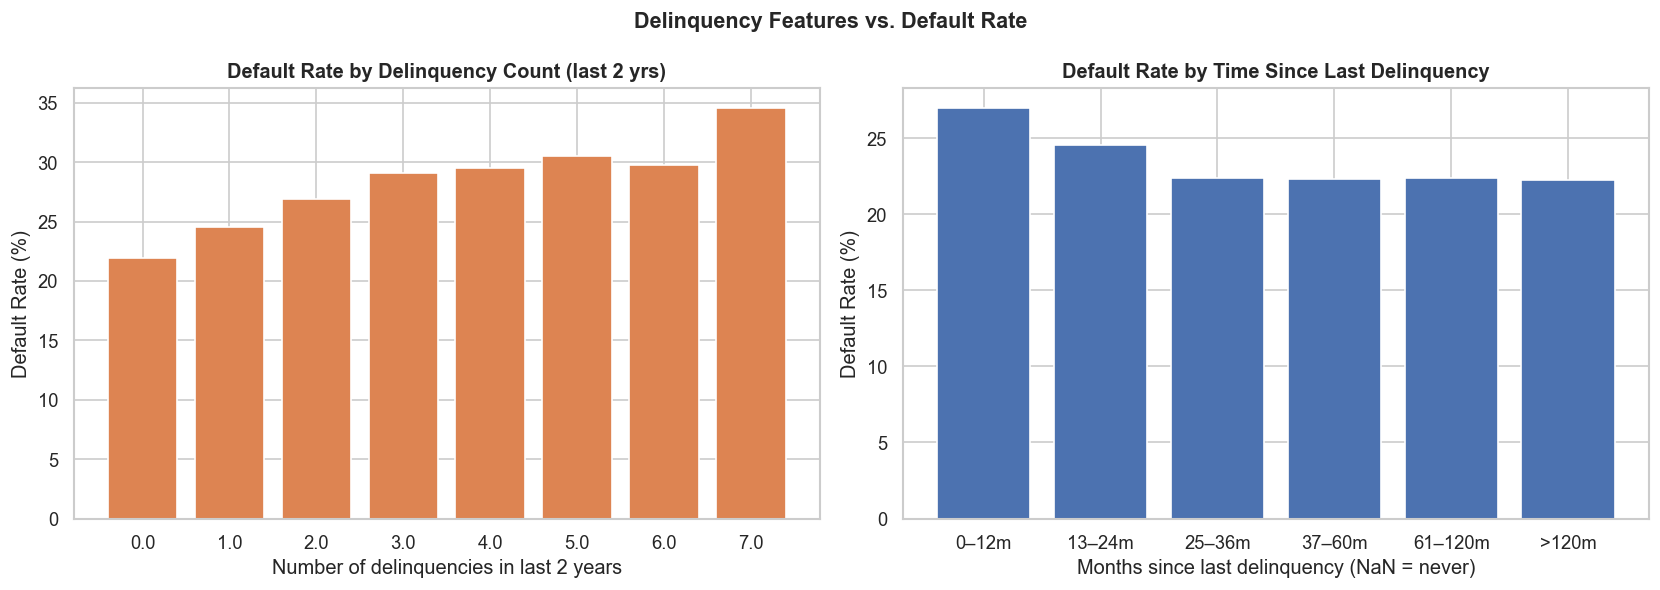

In [11]:
# ── Cross-tabulation: delinquency vs. default rate ───────────────────────────
print("Default rate by delinq_2yrs (number of delinquencies in last 2 years):")
if 'delinq_2yrs' in df_resolved.columns:
    xtab = df_resolved.groupby('delinq_2yrs')['target'].agg(['mean', 'count']).reset_index()
    xtab.columns = ['delinq_2yrs', 'default_rate', 'count']
    xtab['default_pct'] = xtab['default_rate'] * 100
    print(xtab[xtab['count'] > 50].to_string(index=False))

print()
print("Default rate: has ANY delinquency vs. no delinquency:")
if 'delinq_2yrs' in df_resolved.columns:
    df_resolved['has_delinq'] = (df_resolved['delinq_2yrs'] > 0).astype(int)
    delinq_rate = df_resolved.groupby('has_delinq')['target'].mean()
    print(f"  No delinquency (0):  {delinq_rate.get(0, 0)*100:.2f}% default rate")
    print(f"  Any delinquency (1): {delinq_rate.get(1, 0)*100:.2f}% default rate")

# ── Chart: default rate vs. delinquency count ─────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

if 'delinq_2yrs' in df_resolved.columns:
    plot_data = xtab[xtab['count'] > 100].copy()
    axes[0].bar(plot_data['delinq_2yrs'].astype(str), plot_data['default_pct'],
                color='#DD8452', edgecolor='white')
    axes[0].set_xlabel('Number of delinquencies in last 2 years')
    axes[0].set_ylabel('Default Rate (%)')
    axes[0].set_title('Default Rate by Delinquency Count (last 2 yrs)', fontweight='bold')

if 'mths_since_last_delinq' in df_resolved.columns:
    # Bin months since last delinquency
    bins = [0, 12, 24, 36, 60, 120, 999]
    labels = ['0–12m', '13–24m', '25–36m', '37–60m', '61–120m', '>120m']
    df_resolved['delinq_age_bin'] = pd.cut(df_resolved['mths_since_last_delinq'].fillna(999),
                                            bins=bins, labels=labels, right=False)
    bin_rate = df_resolved.groupby('delinq_age_bin', observed=False)['target'].mean() * 100
    axes[1].bar(bin_rate.index.astype(str), bin_rate.values, color='#4C72B0', edgecolor='white')
    axes[1].set_xlabel('Months since last delinquency (NaN = never)')
    axes[1].set_ylabel('Default Rate (%)')
    axes[1].set_title('Default Rate by Time Since Last Delinquency', fontweight='bold')

plt.suptitle('Delinquency Features vs. Default Rate', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/delinquency_analysis.png', bbox_inches='tight')
plt.show()


### Interpretation: Delinquency Features

**Why delinquency features matter in credit risk:**

In lending, past behavior is the strongest predictor of future behavior. A borrower who has been 30, 60, or 90 days late on a payment in the past is statistically far more likely to default on their current loan than one with a clean history. Lenders pay close attention to:

- **Recency**: Was the delinquency last month or 5 years ago? Recent delinquencies signal current financial stress.
- **Severity**: A 90-day late payment is far more alarming than a 30-day one — it suggests inability to pay, not just a missed payment.
- **Frequency**: One late payment may be a billing error. Multiple delinquencies signal a pattern.

**Data quality flags:**
- Missing `mths_since_last_delinq` means the borrower has *never been delinquent* — this is **not** random missingness. We should NOT impute with the median here; instead we'll create a `has_delinquency` binary flag and fill missing with a large value (e.g., 999) indicating "never."
- Any values of **96, 97, 98, or 99** in integer delinquency count columns are likely sentinel codes (used in some datasets to mean "unknown" or "not available"). We'll verify and treat them as missing if found.


---
## Summary of Findings

### Dataset Overview
- **Shape:** To be computed from df_resolved (approximately 800k+ resolved loans × 74 columns)
- **Time period:** Lending Club loans, earliest ~2007 through mid-2010s
- **Source:** Kaggle, Lending Club public data (GPL-2.0 license)

### Target Variable
- **Binary target:** `loan_status` → Default (1) vs. Fully Paid (0)
- **Excluded:** Current, In Grace Period, and other unresolved loans (no known outcome)
- **Class imbalance:** Approximately 4–5:1 (Fully Paid : Default). All modeling must account for this.

### Missing Data — Ranked by Severity

| Severity | Columns | Action |
|----------|---------|--------|
| **Structural** (>50% missing) | Joint application columns (`annual_inc_joint`, etc.) | **Drop** — only applies to joint applications, not relevant for majority of loans |
| **Informative** missingness | `mths_since_last_delinq`, `mths_since_last_record` | **Create binary flag** + fill missing with 999 (never happened) |
| **High missingness** (20–50%) | `mths_since_last_major_derog`, various installment cols | Decision needed — drop or impute |
| **Moderate** (5–15%) | `emp_length`, `revol_util` | **Median imputation** or mode (categorical) |
| **Low** (<5%) | Most other numeric cols | **Median imputation** |

### Outlier Concerns

| Column | Issue | Recommendation |
|--------|-------|----------------|
| `annual_inc` | Values > $500k likely real but extreme | Cap at 99th percentile |
| `dti` | Values > 60–100 are implausible | Cap at 99th percentile or review |
| `revol_util` | > 100% is impossible | Treat > 100 as data error → NaN |
| `revol_bal` | Extreme right tail | Cap at 99th percentile |

### Multicollinearity Candidates
- `loan_amnt` / `funded_amnt` / `funded_amnt_inv` — nearly identical; keep `loan_amnt`
- `loan_amnt` / `installment` — highly correlated; both may be kept as installment also encodes term+rate
- Post-loan performance features (`total_pymnt`, `total_rec_prncp`, `out_prncp`) — **data leakage**; these are known only *after* the loan resolves and must be dropped

### Most Predictive Features (Preliminary)
Based on point-biserial correlations, the strongest signals are likely:
1. `int_rate` — Lending Club's risk-based rate
2. `grade` / `sub_grade` — Lending Club's credit tier
3. `dti` — debt-to-income ratio
4. `revol_util` — credit utilization
5. `delinq_2yrs` — recent delinquency history
6. `inq_last_6mths` — recent credit applications (inquiry count)

### Open Questions for User
These require your decisions before we proceed to NB02.


In [12]:
# ── Print final summary stats ─────────────────────────────────────────────────
print("=" * 60)
print("NB01 FINAL SUMMARY")
print("=" * 60)
print(f"Full dataset shape:       {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Resolved loans (for ML):  {df_resolved.shape[0]:,} rows")
print(f"Excluded (unresolved):    {df.shape[0] - df_resolved.shape[0]:,} rows")
print()
target_counts = df_resolved['target'].value_counts()
print(f"Target distribution:")
print(f"  Fully Paid (0): {target_counts[0]:,} ({target_counts[0]/len(df_resolved)*100:.1f}%)")
print(f"  Default    (1): {target_counts[1]:,} ({target_counts[1]/len(df_resolved)*100:.1f}%)")
print(f"  Ratio:          {target_counts[0]/target_counts[1]:.1f}:1")
print()
print(f"Columns with missing data: {(df_resolved.isnull().sum() > 0).sum()}")
print(f"Avg income (median):       ${df_resolved['annual_inc'].median():,.0f}")
print(f"Avg loan amount (median):  ${df_resolved['loan_amnt'].median():,.0f}")
print(f"Avg int rate (median):     {df_resolved['int_rate'].median():.1f}%")
print(f"Avg DTI (median):          {df_resolved['dti'].median():.1f}%")
print()
print("Outputs saved to: outputs/")
print("  - target_distribution.png")
print("  - missing_values.png")
print("  - numeric_distributions.png")
print("  - categorical_distributions.png")
print("  - correlation_heatmap.png")
print("  - delinquency_analysis.png")


NB01 FINAL SUMMARY
Full dataset shape:       887,379 rows × 74 columns
Resolved loans (for ML):  270,887 rows
Excluded (unresolved):    616,492 rows

Target distribution:
  Fully Paid (0): 209,711 (77.4%)
  Default    (1): 61,176 (22.6%)
  Ratio:          3.4:1

Columns with missing data: 41
Avg income (median):       $62,000
Avg loan amount (median):  $12,000
Avg int rate (median):     13.7%
Avg DTI (median):          16.4%

Outputs saved to: outputs/
  - target_distribution.png
  - missing_values.png
  - numeric_distributions.png
  - categorical_distributions.png
  - correlation_heatmap.png
  - delinquency_analysis.png
